<a href="https://www.kaggle.com/code/amirhosseinzinati/diabetes-logistic-regression?scriptVersionId=134260033" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv("/kaggle/input/diabetes-data-set/diabetes.csv")
data.head(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
5,5,116,74,0,0,25.6,0.201,30,0
6,3,78,50,32,88,31.0,0.248,26,1
7,10,115,0,0,0,35.3,0.134,29,0
8,2,197,70,45,543,30.5,0.158,53,1
9,8,125,96,0,0,0.0,0.232,54,1


In [3]:
# information of dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [4]:
# Check For Missing Values
info = pd.DataFrame(data.isnull().sum(),columns=["IsNull"])
info.insert(1,"IsNa",data.isna().sum(),True)
info.insert(2,"Duplicate",data.duplicated().sum(),True)
info.insert(3,"Unique",data.nunique(),True)
info.insert(4,"Min",data.min(),True)
info.insert(5,"Max",data.max(),True)
info.T    

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
IsNull,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0
IsNa,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0
Duplicate,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0
Unique,17.0,136.0,47.0,51.0,186.0,248.0,517.000,52.0,2.0
Min,0.0,0.0,0.0,0.0,0.0,0.0,0.078,21.0,0.0
Max,17.0,199.0,122.0,99.0,846.0,67.1,2.420,81.0,1.0


# Preproccessing

In [5]:
df=data.copy()

In [6]:
def diagnostic_plots(df, variable,target):
    # The function takes a dataframe (df) and
    # the variable of interest as arguments.

    # Define figure size.
    plt.figure(figsize=(20, 7))

    # histogram
    plt.subplot(1, 4, 1)
    sns.histplot(df[variable], kde = True,color='r')
    plt.title('Histogram')


    # scatterplot
    plt.subplot(1, 4, 2)
    plt.scatter(df[variable],df[target],color = 'g')
    plt.title('Scatterplot')
    
    
    # boxplot
    plt.subplot(1, 4, 3)
    sns.boxplot(y=df[variable],color = 'b')
    plt.title('Boxplot')
    
    # barplot
    plt.subplot(1, 4, 4)
    sns.barplot(x = target, y = variable, data = df)   
    plt.title('Barplot')
    
    
    plt.show()

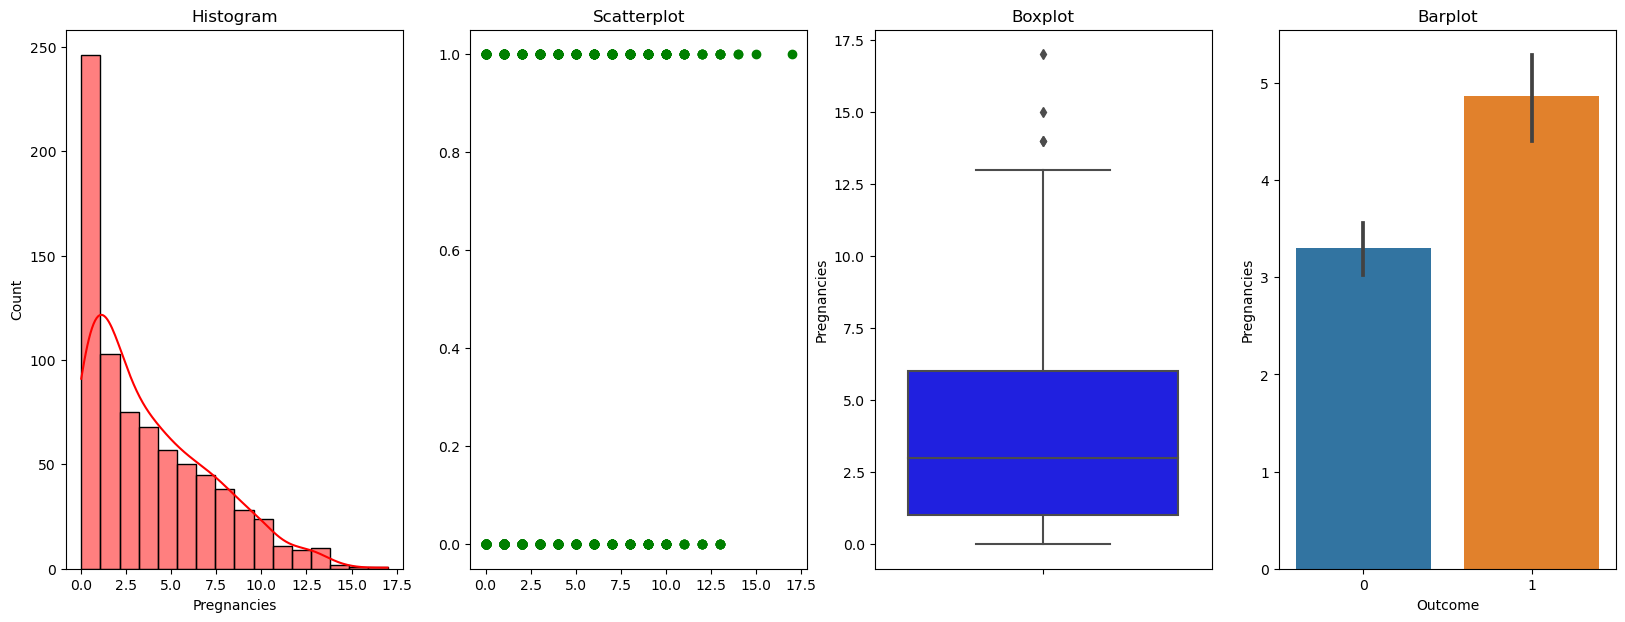

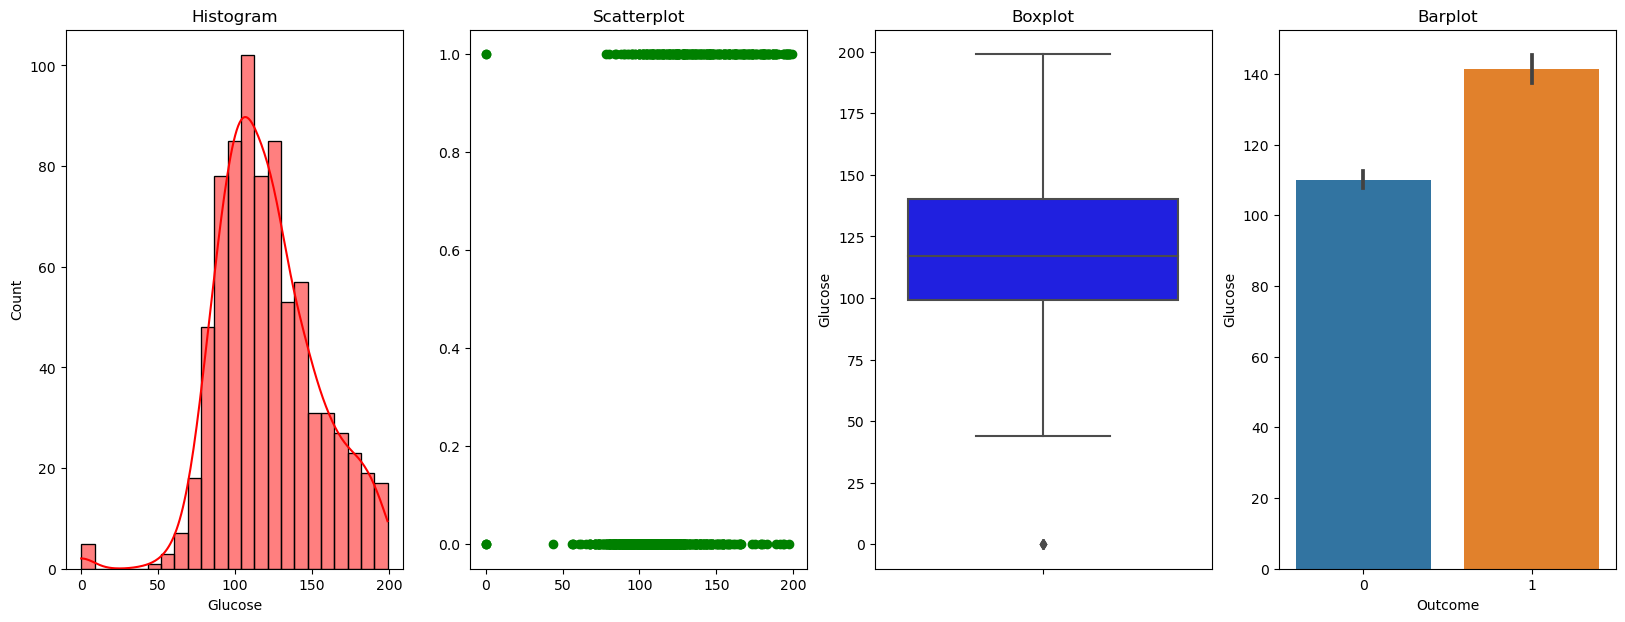

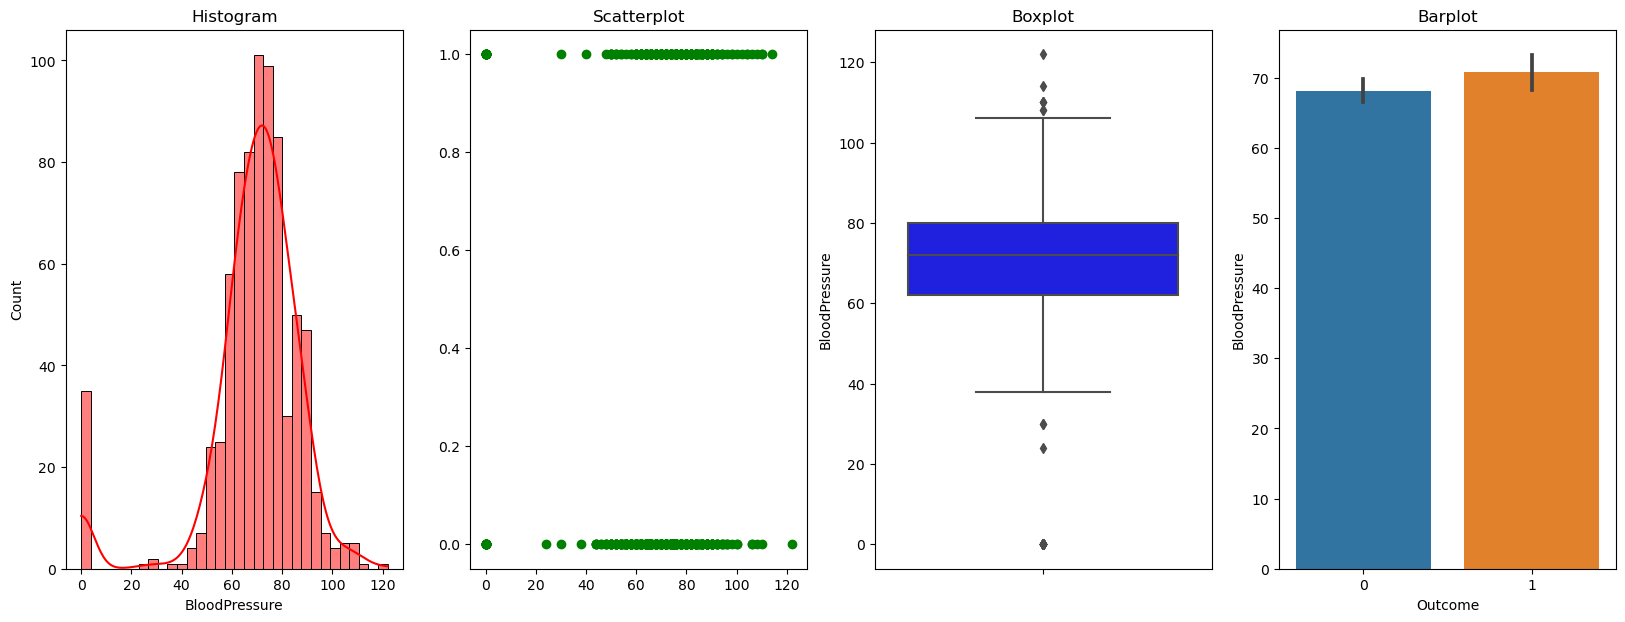

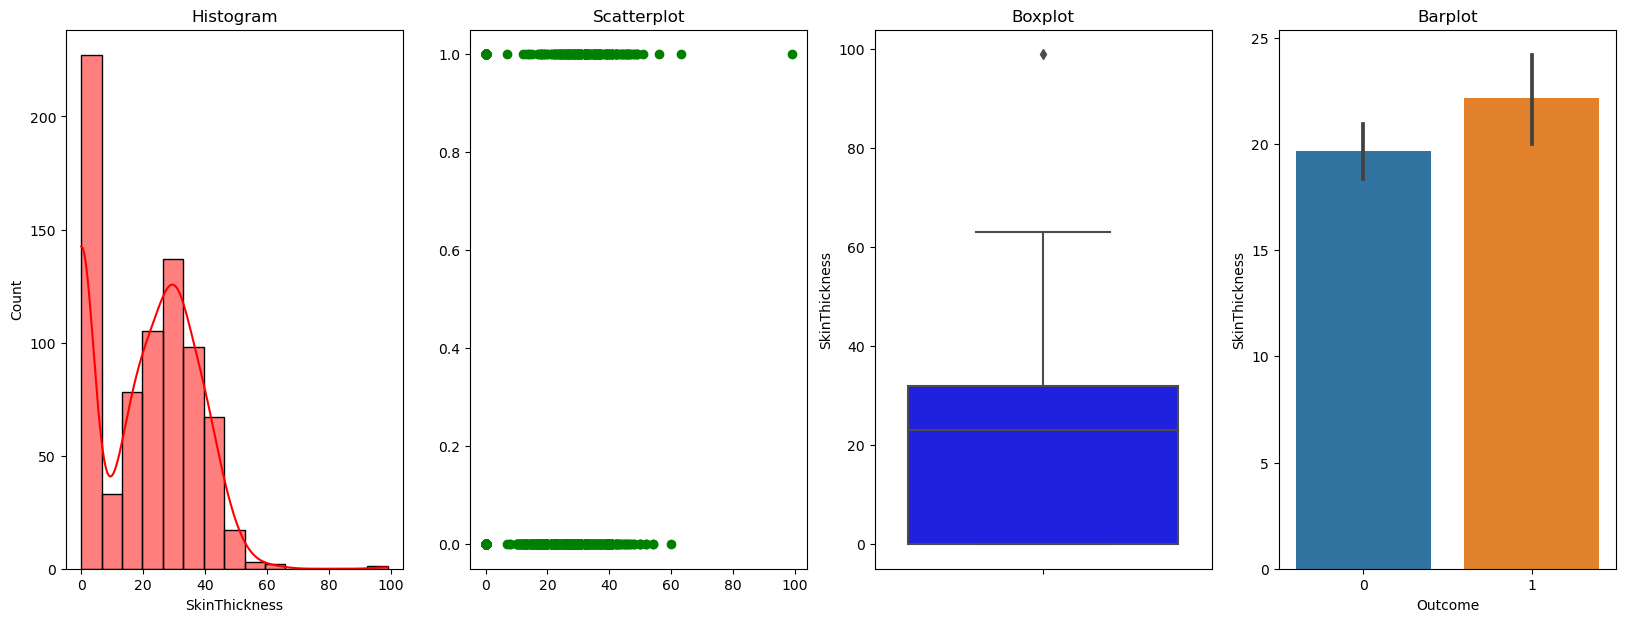

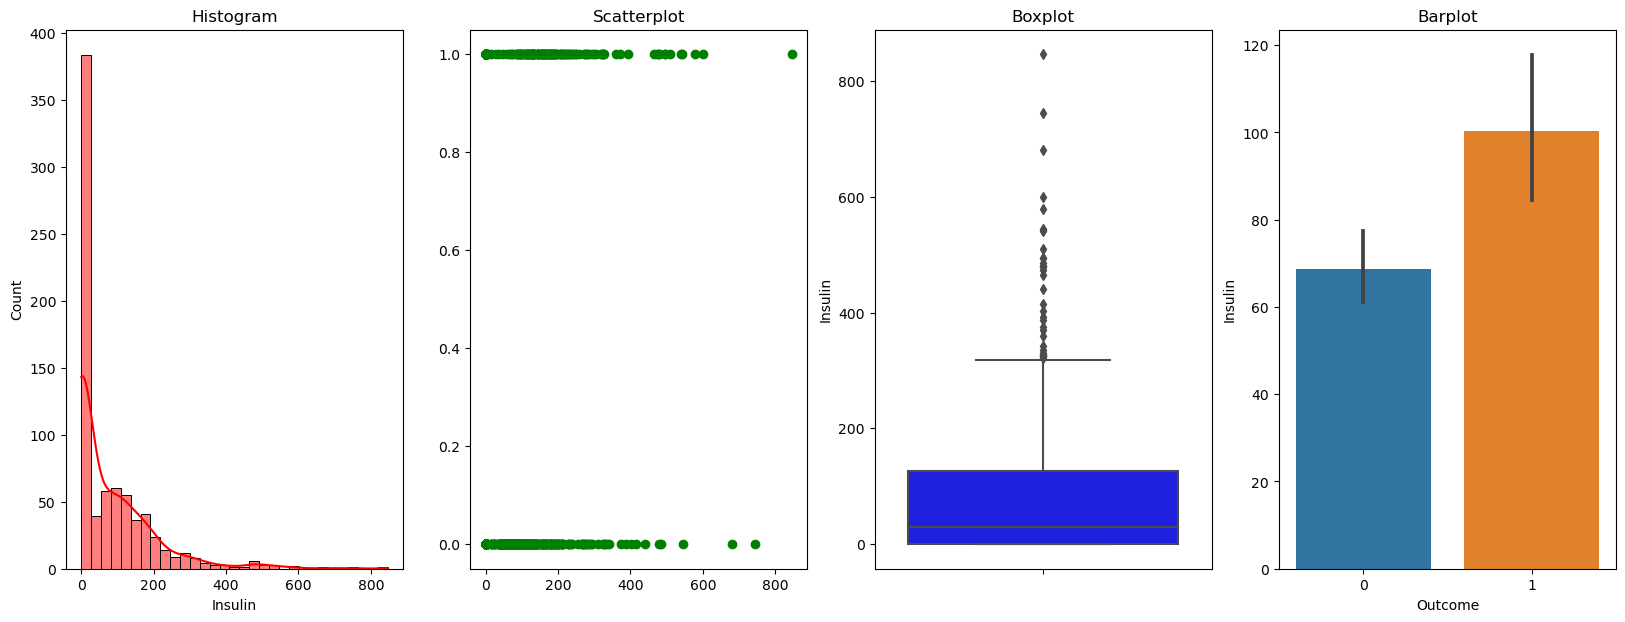

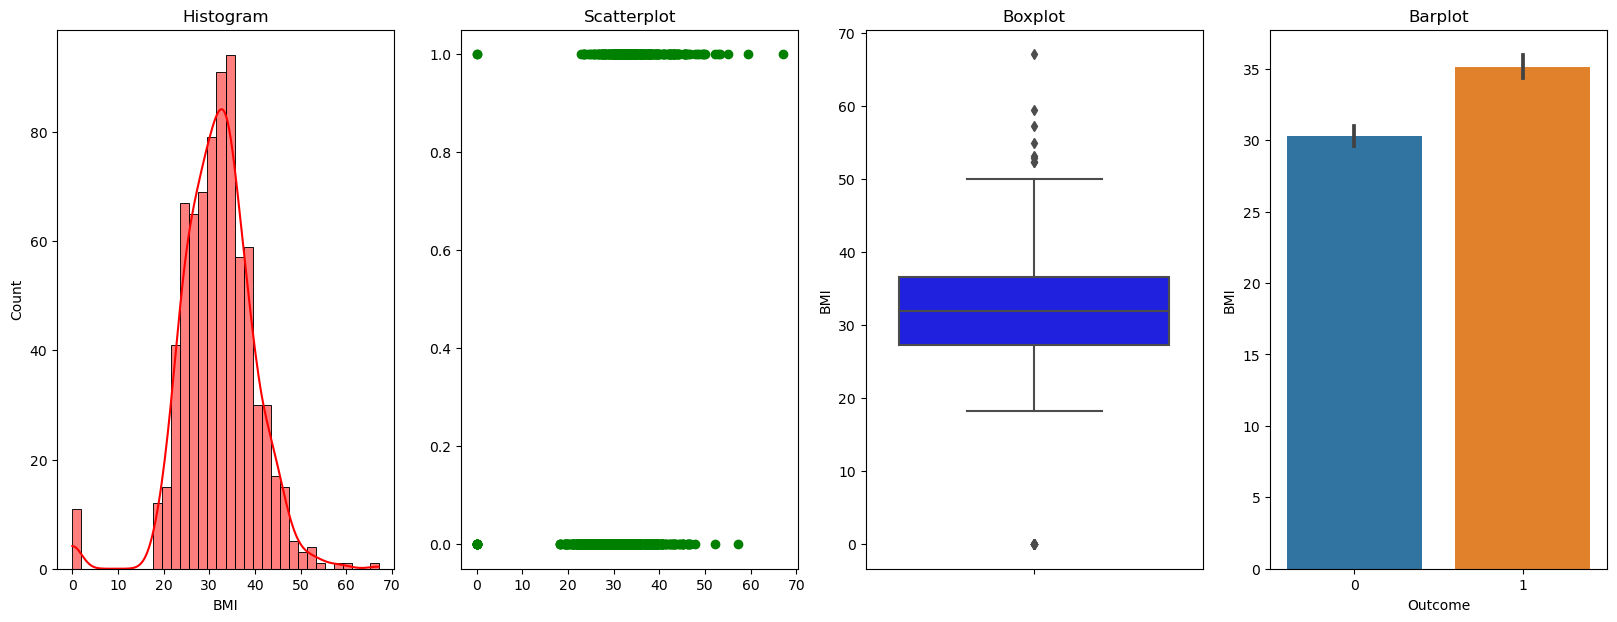

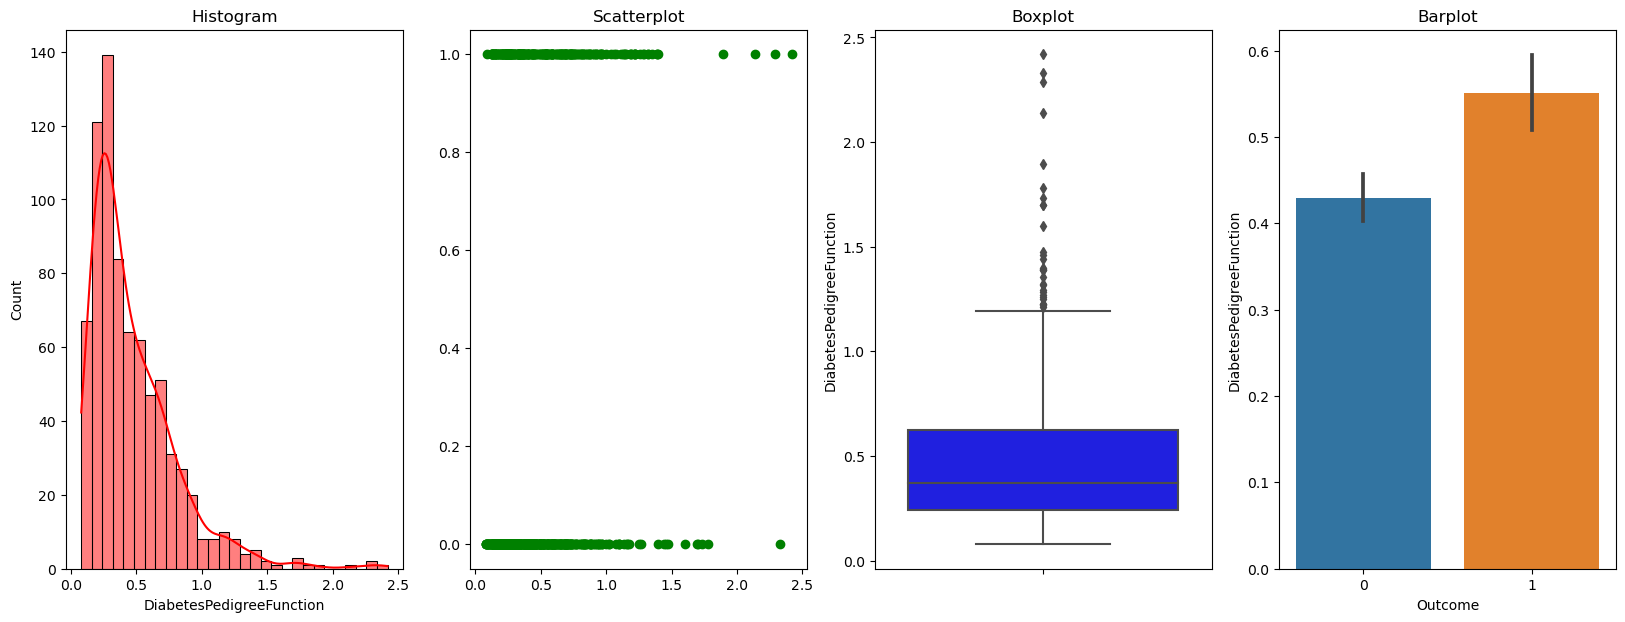

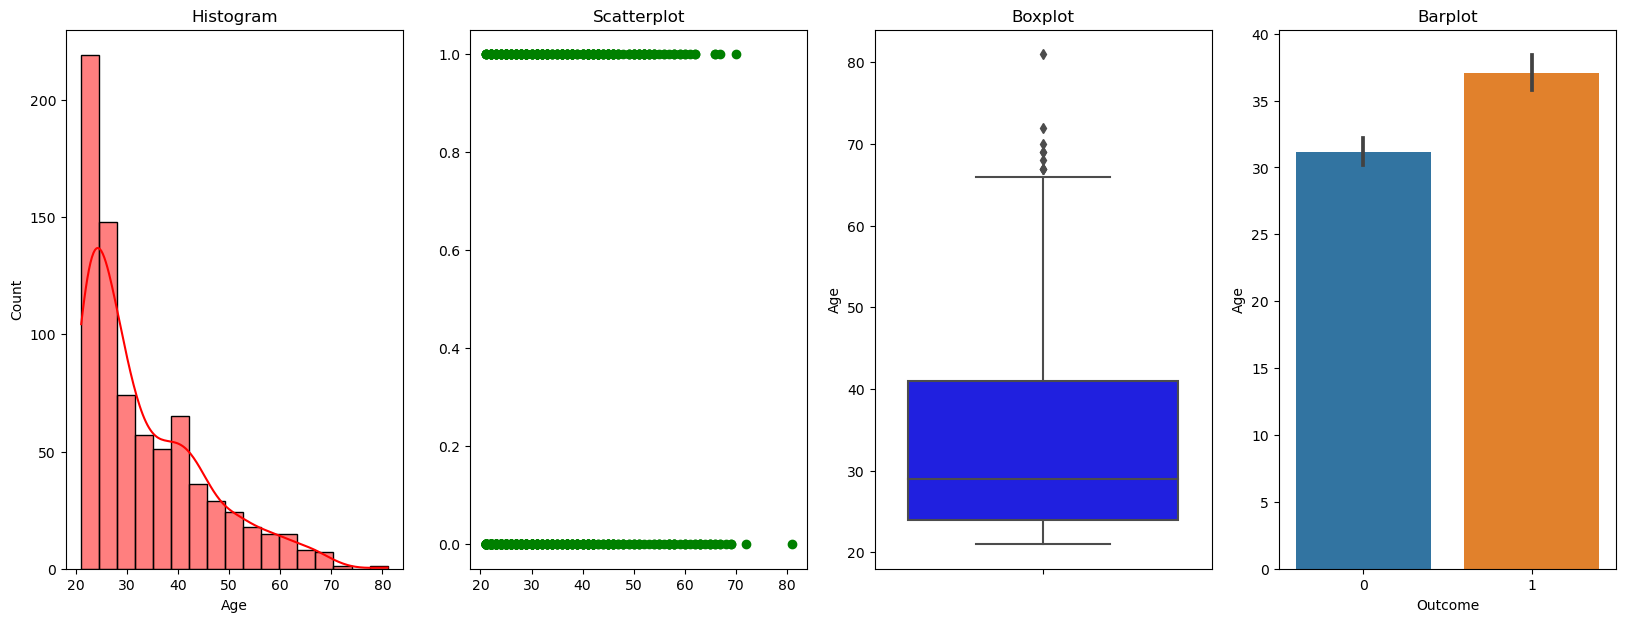

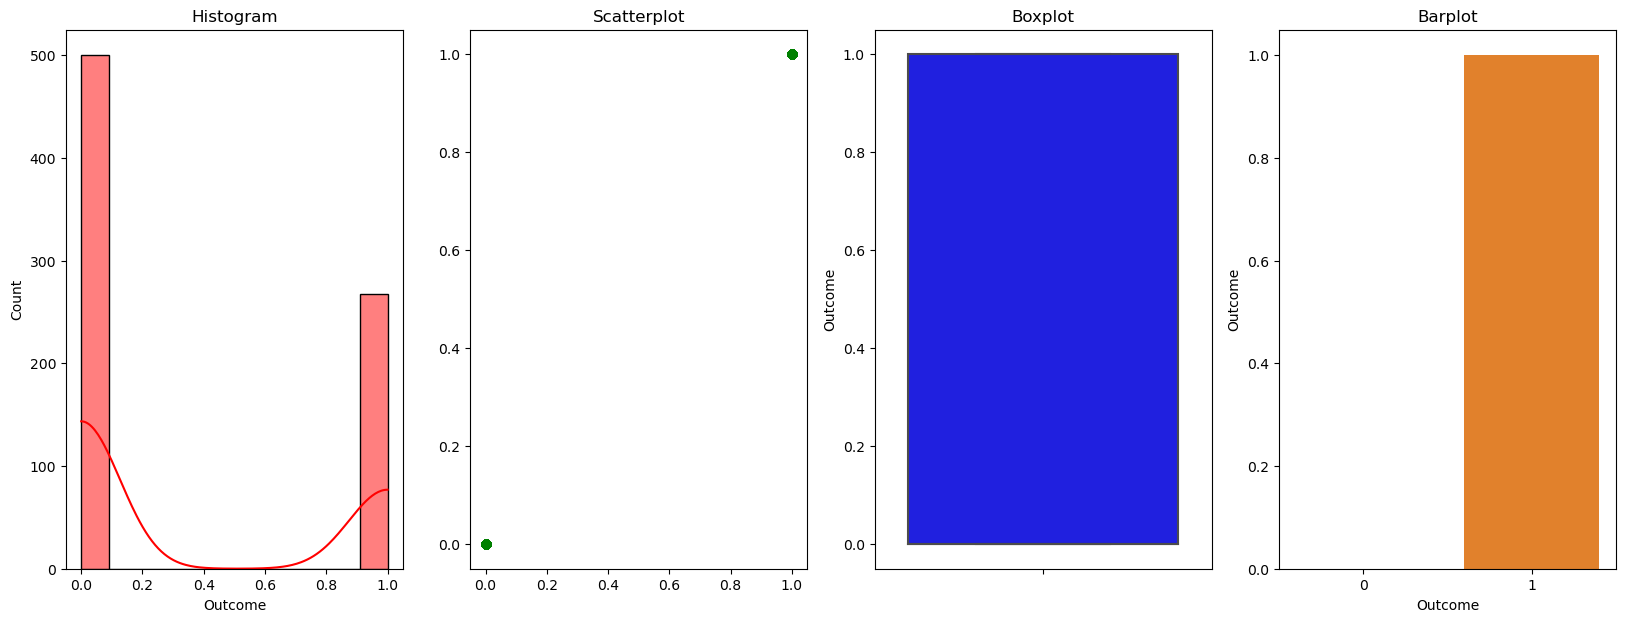

In [7]:
for col in df:
    diagnostic_plots(df,col,'Outcome')

Interpretation of Outliers.
* In boxplot of pregnancy the plot is showing outliers for 13,15 and 17 pregnancies but I will not remove them from data as it is possible for a women to bear 17 childs.
* In boxplot of glucose column, the outlier is shown at 0 which is not possible a women cannot have a zero glucose level.So, I will remove it.
* In boxplot of blood pressure column, outliers below lower quartiles require removal but upper don't.
* The outlier in skin thickness column is too far from the upper quartile so I will prefer to remove it.
* In boxplot of insulin, insulin level are quite fluctuating so I will not consider them as outliers
* In boxplot of BMI, a BMI of 0 cannot exist so I will remove it
* In boxplot of diabetes pedigree function, scores can vary based on family history. So, I will not remove them.
* The boxplot of age column also depicts some outliers but people with such ages can exist, so, I will not remove them.

In [8]:
# Getting zero and less than zero values counts in each column
# Glucose	BloodPressure	SkinThickness	Insulin	BMI
cols= df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']]
for col in cols:
    zero_values = len(df[df[col] <= 0])
    print("Number of zero or less tha zero values in column {} are {}".format(col,zero_values))

Number of zero or less tha zero values in column Glucose are 5
Number of zero or less tha zero values in column BloodPressure are 35
Number of zero or less tha zero values in column SkinThickness are 227
Number of zero or less tha zero values in column Insulin are 374
Number of zero or less tha zero values in column BMI are 11


* In skin thickness and insuli boxplot, the plot is starting from zero which is weird because a human even a pregnant female cannot have zero skin thickness and insulin level. So, I will replace the values equal to zero in these columns with the median of the column values.

In [9]:
cols= df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']]
for col in cols:
    median = df[col].median()
    df.loc[df[col]<=0,col] = median

In [10]:
cols= df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']]
for col in cols:
    zero_values = len(df[df[col] <= 0])
    print("Number of zero or less tha zero values in column {} are {}".format(col,zero_values))

Number of zero or less tha zero values in column Glucose are 0
Number of zero or less tha zero values in column BloodPressure are 0
Number of zero or less tha zero values in column SkinThickness are 0
Number of zero or less tha zero values in column Insulin are 0
Number of zero or less tha zero values in column BMI are 0


In [11]:
def mod_outlier(df):
        df1 = df.copy()
        df = df._get_numeric_data()
        q1 = df.quantile(0.25)
        q3 = df.quantile(0.75)

        iqr = q3 - q1

        lower_bound = q1 -(1.5 * iqr) 
        upper_bound = q3 +(1.5 * iqr)


        for col in df.columns:
            for i in range(0,len(df[col])):
                if df[col][i] < lower_bound[col]:            
                    df[col][i] = lower_bound[col]

                if df[col][i] > upper_bound[col]:            
                    df[col][i] = upper_bound[col]    


        for col in df.columns:
            df1[col] = df[col]

        return(df1)

In [12]:
df1 = mod_outlier(df)

/tmp/ipykernel_20/926679308.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col][i] = upper_bound[col]
/tmp/ipykernel_20/926679308.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col][i] = lower_bound[col]


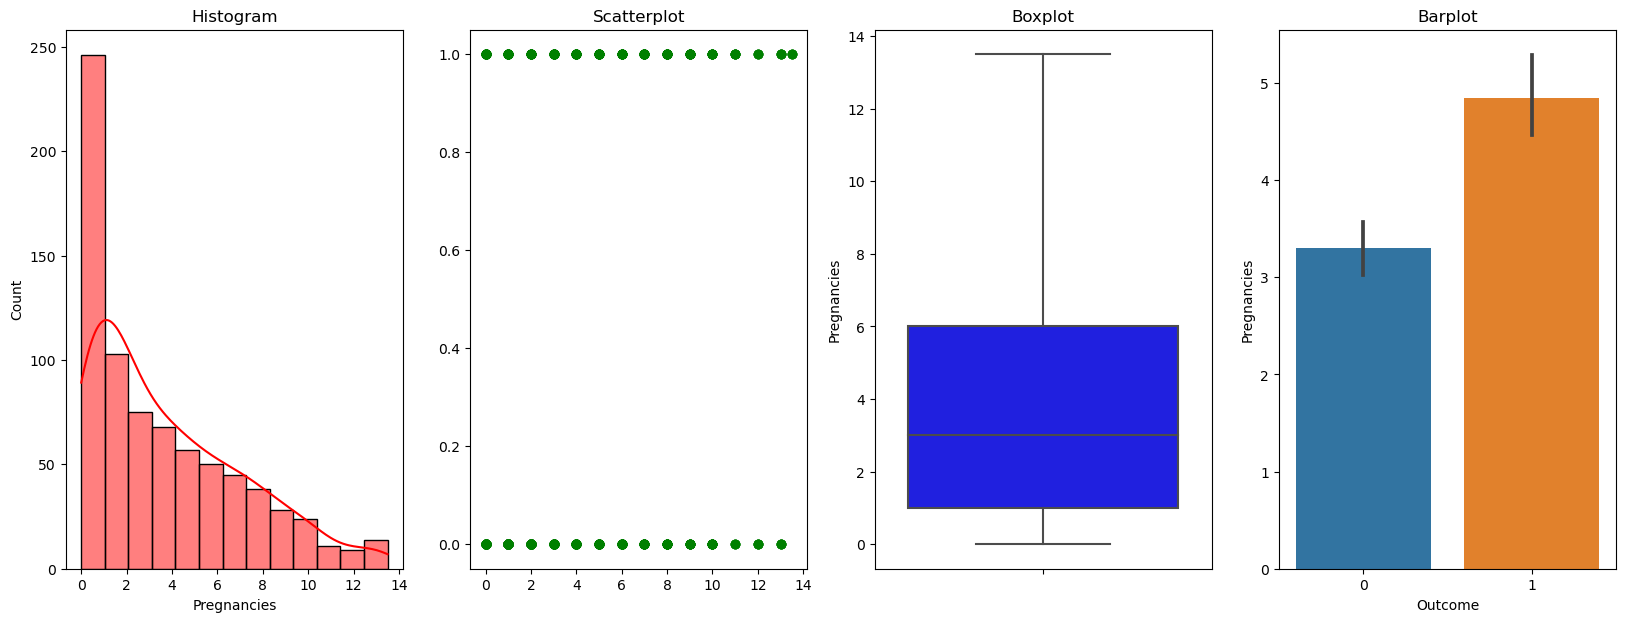

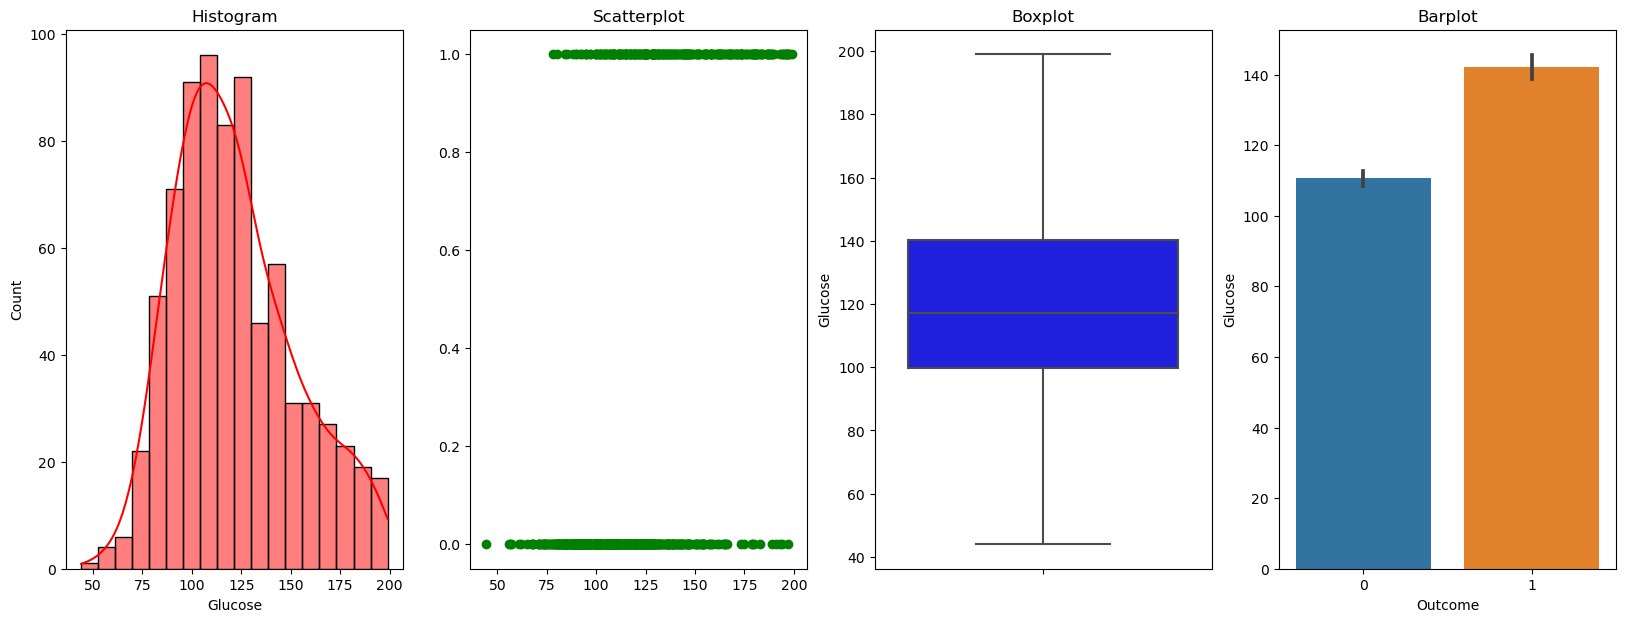

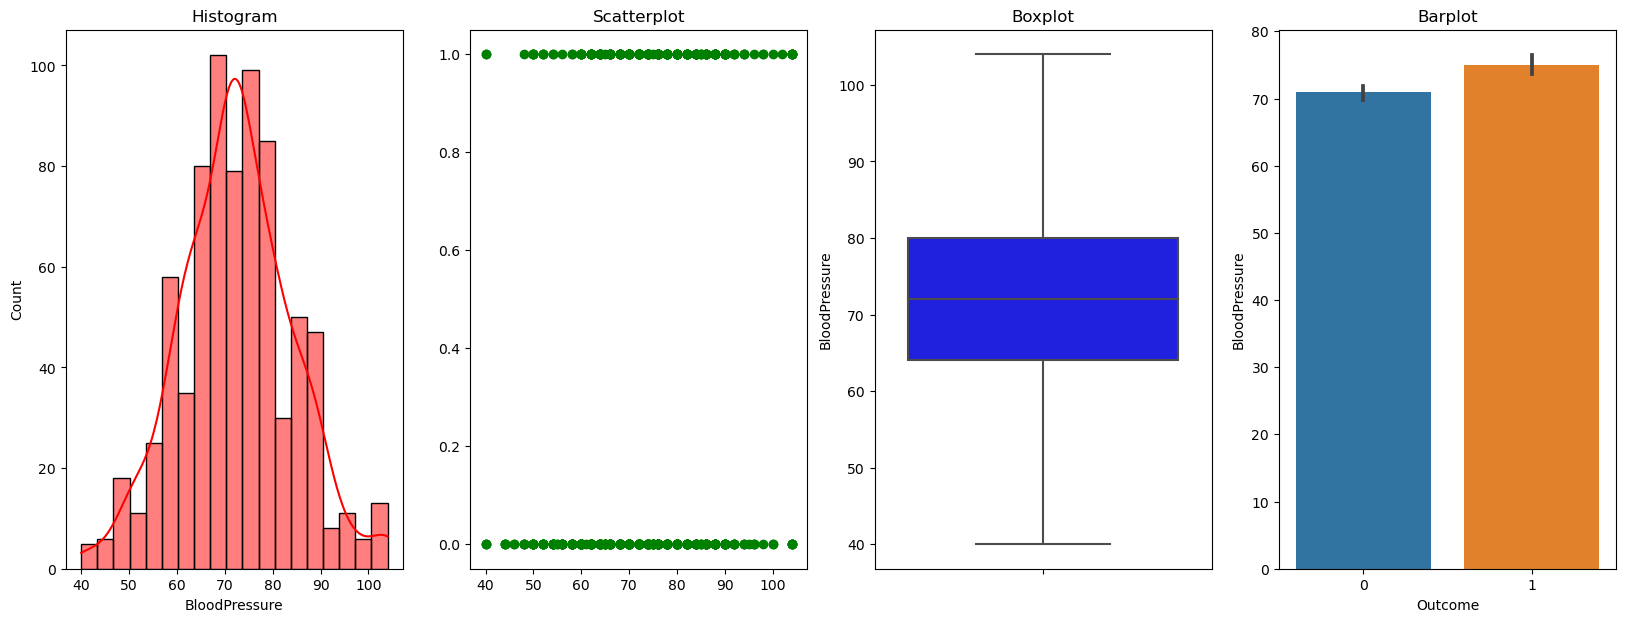

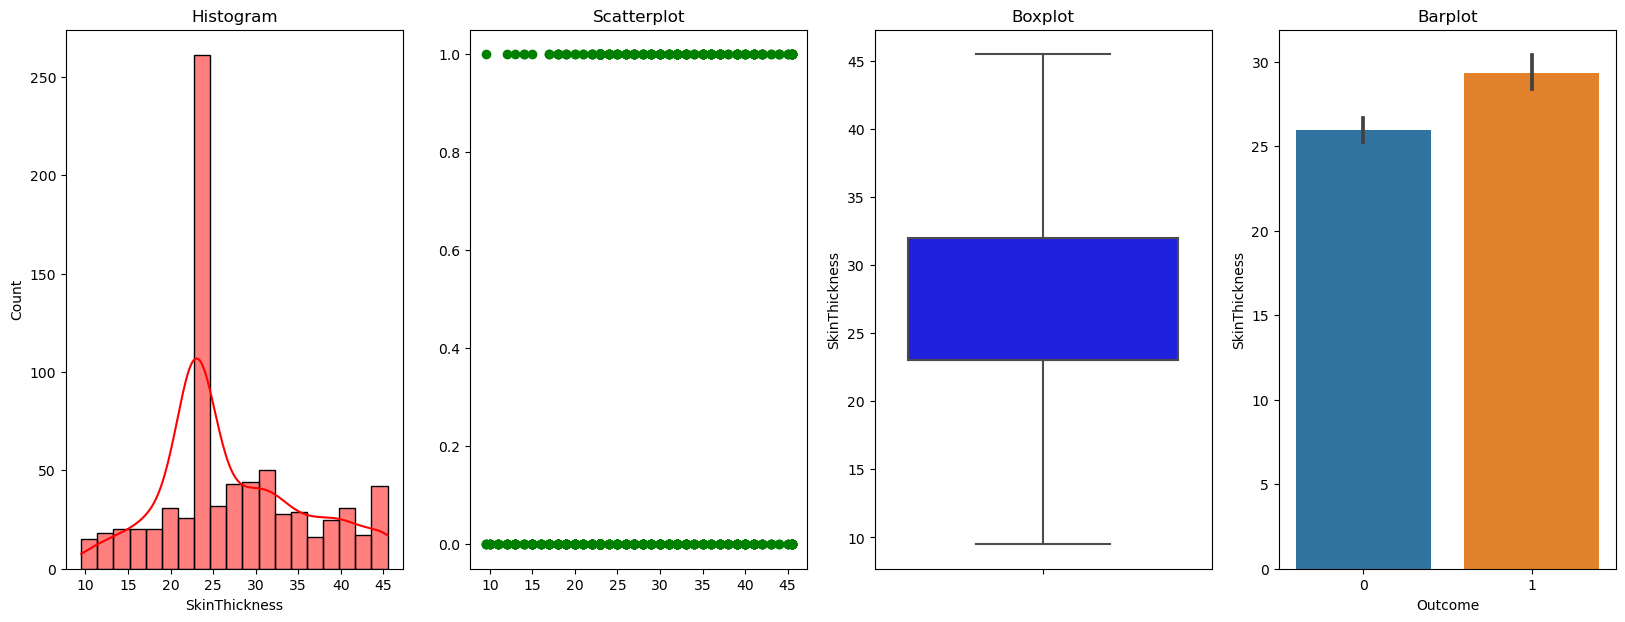

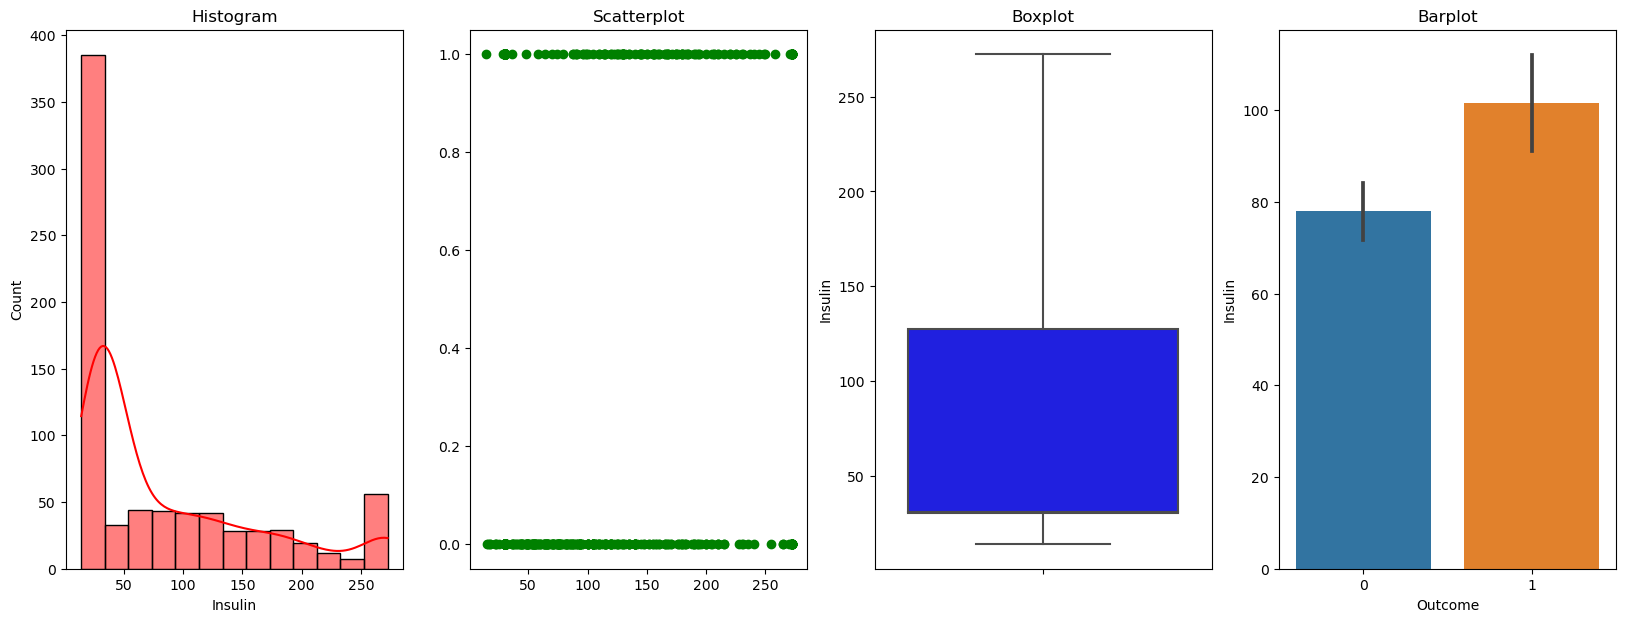

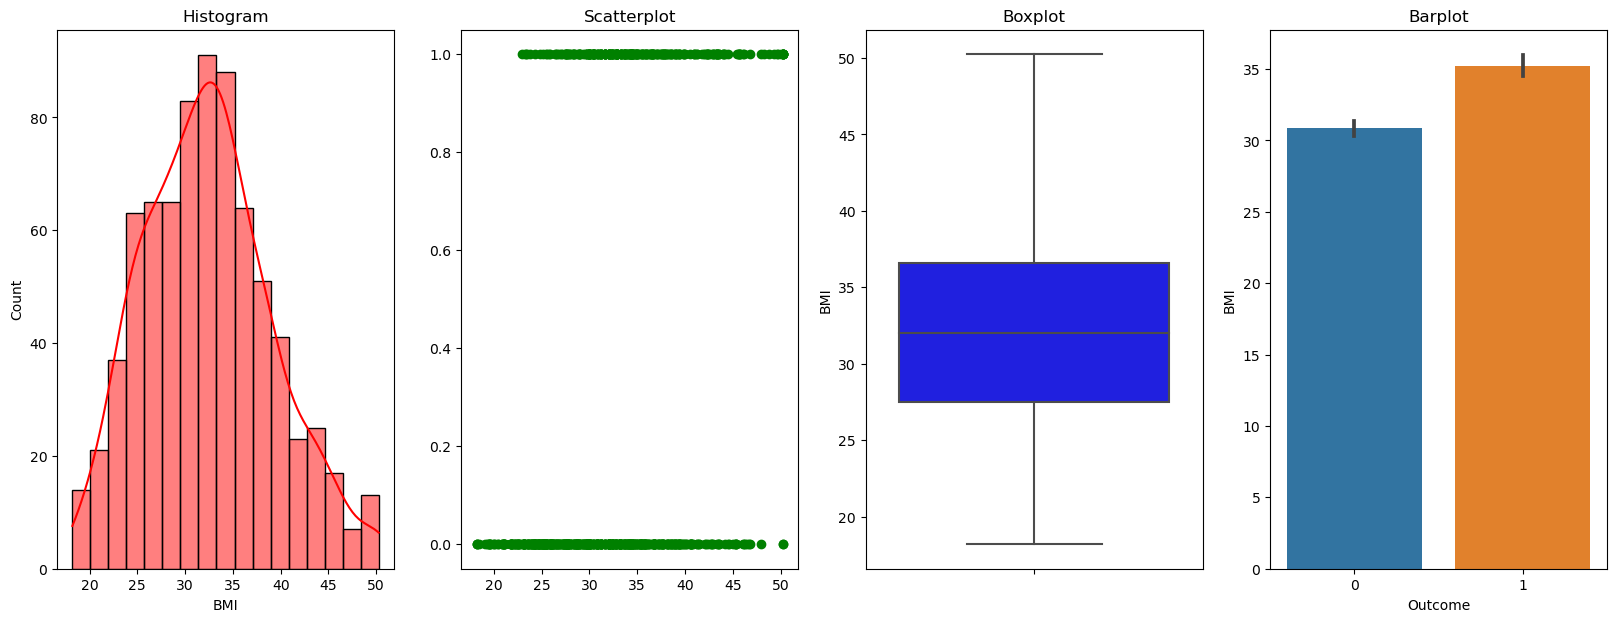

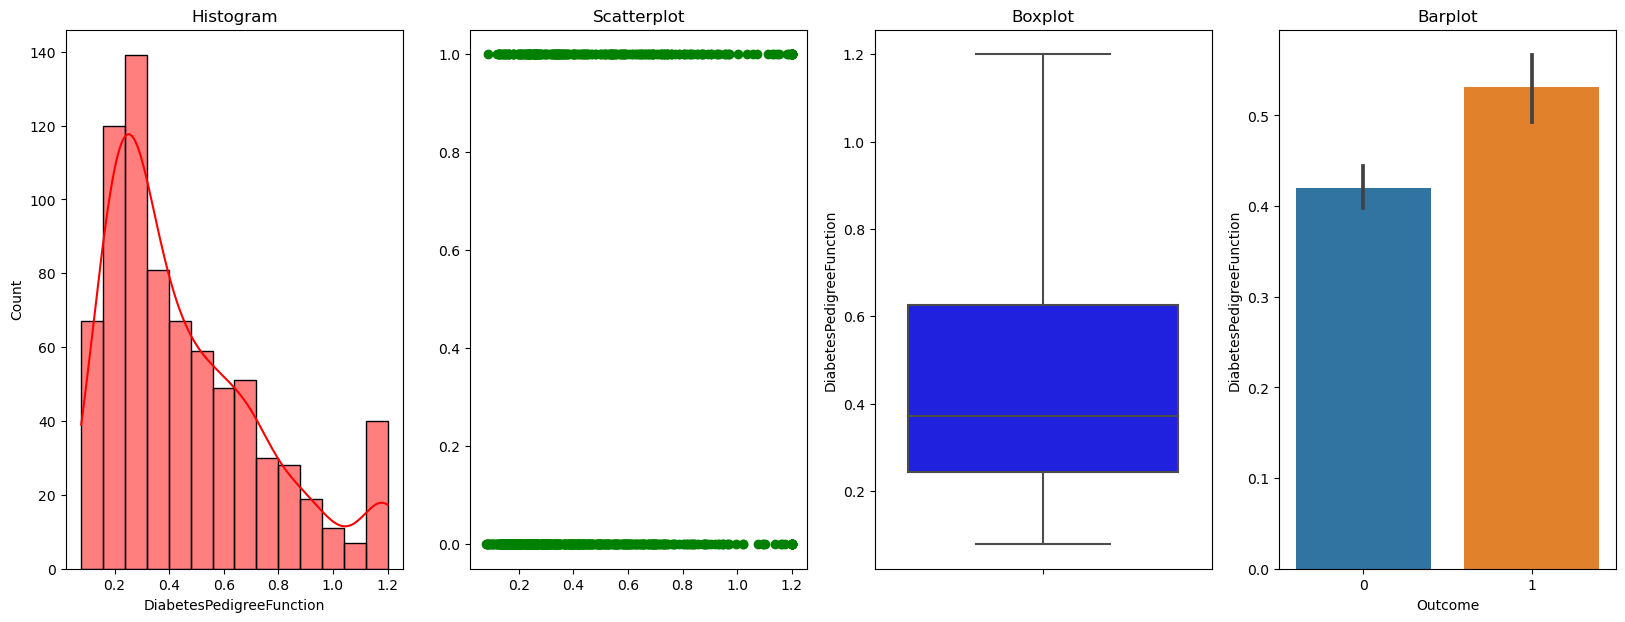

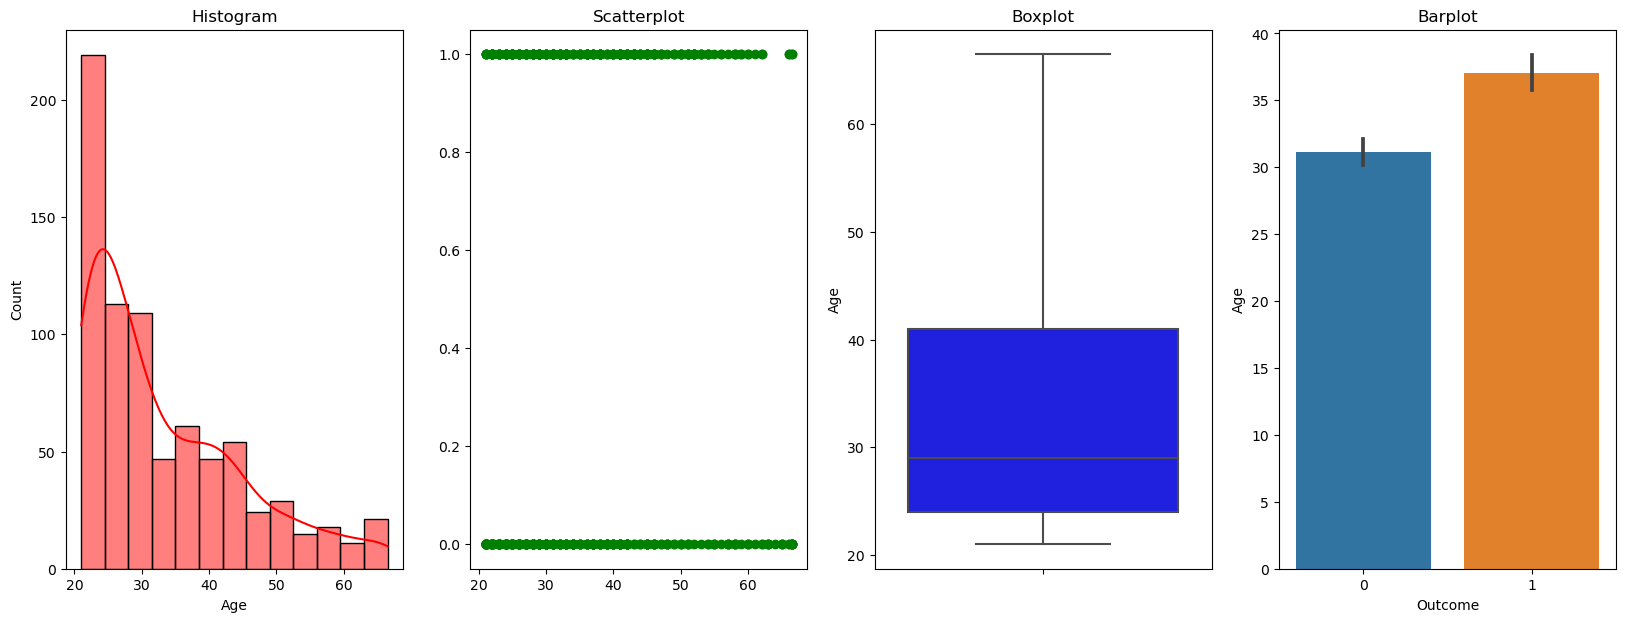

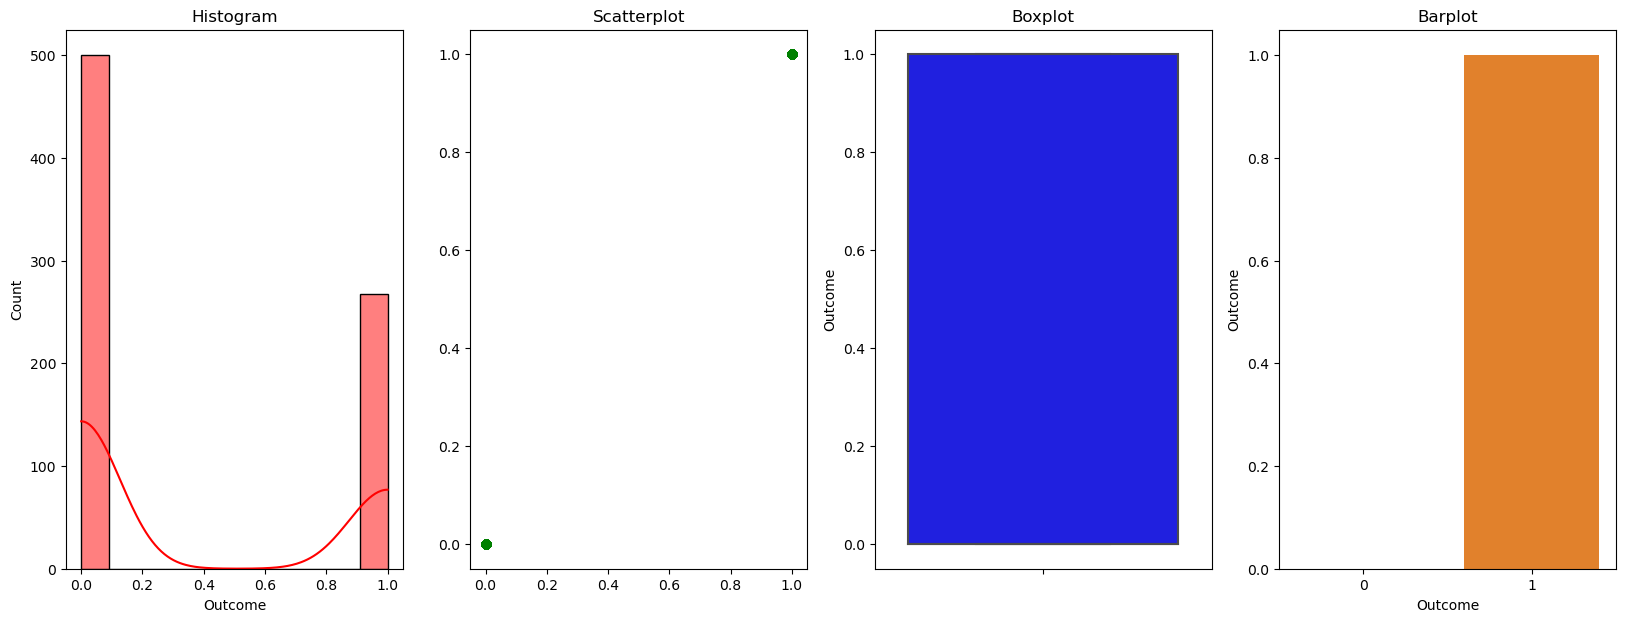

In [13]:
for col in df1:
    diagnostic_plots(df1,col,'Outcome')

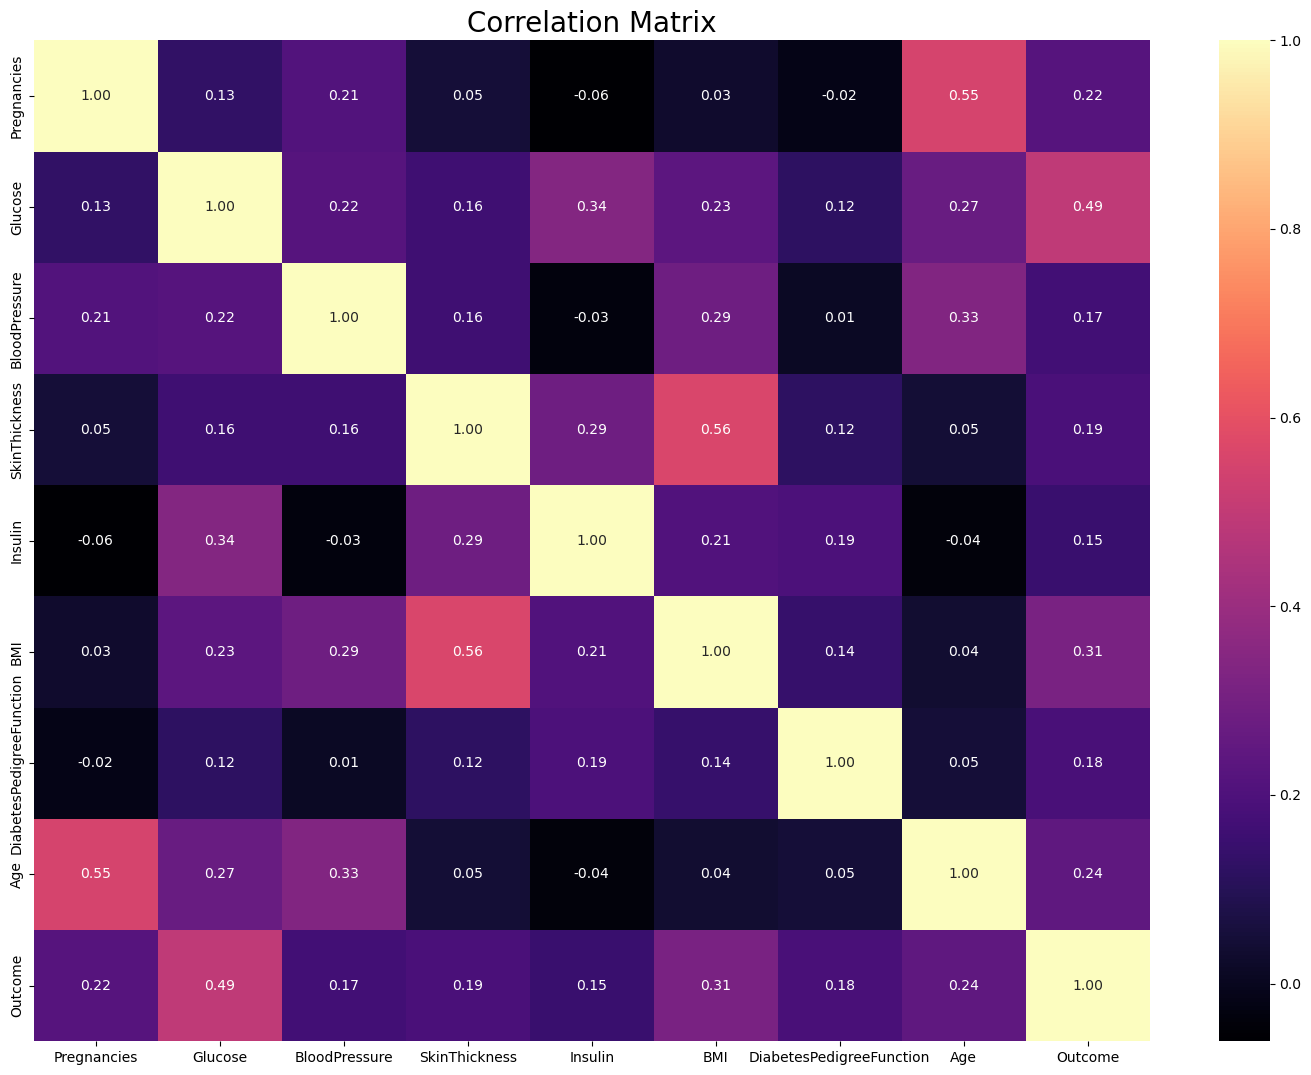

In [14]:
# Correlation matrix
f, ax = plt.subplots(figsize=[18, 13])
sns.heatmap(df1.corr(), annot=True, fmt=".2f", ax=ax, cmap="magma")
ax.set_title("Correlation Matrix", fontsize=20)
plt.show()

In [15]:
df1

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6.0,148,72,35.0,30.5,33.6,0.627,50.0,1
1,1.0,85,66,29.0,30.5,26.6,0.351,31.0,0
2,8.0,183,64,23.0,30.5,23.3,0.672,32.0,1
3,1.0,89,66,23.0,94.0,28.1,0.167,21.0,0
4,0.0,137,40,35.0,168.0,43.1,1.200,33.0,1
...,...,...,...,...,...,...,...,...,...
763,10.0,101,76,45.5,180.0,32.9,0.171,63.0,0
764,2.0,122,70,27.0,30.5,36.8,0.340,27.0,0
765,5.0,121,72,23.0,112.0,26.2,0.245,30.0,0
766,1.0,126,60,23.0,30.5,30.1,0.349,47.0,1


In [16]:
X= df1[["Pregnancies","Glucose","BloodPressure","SkinThickness","Insulin","BMI","DiabetesPedigreeFunction","Age"]]
y = df1.Outcome

In [17]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=43)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (576, 8)
y_train shape: (576,)
X_test shape: (192, 8)
y_test shape: (192,)


# Normalizzation

In [18]:
# As features are measured using different unit of measurements, we can normalize or scale them.
from sklearn.preprocessing import MinMaxScaler

st =MinMaxScaler()
X_train = st.fit_transform(X_train)
X_test = st.fit_transform(X_test)

# Model

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics,metrics

clf = LogisticRegression(max_iter=100,multi_class="ovr",penalty="l1",solver="saga")
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
score = metrics.accuracy_score(y_test,y_pred)
print ("with solver saga score is : {}".format(score))

with solver saga score is : 0.8020833333333334


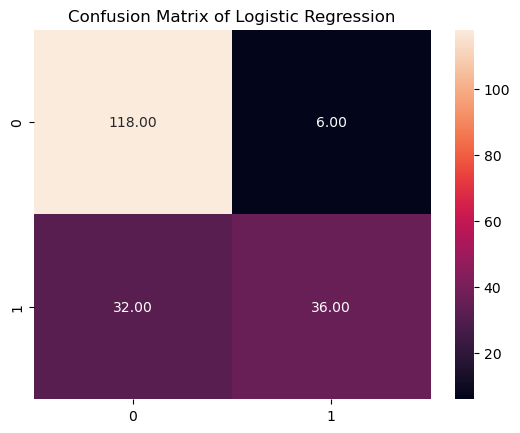

In [20]:
# computing the confusion matrix for Logreg model and visualizing it using heatmap
final_logreg_cm = metrics.confusion_matrix(y_test,y_pred)

sns.heatmap(final_logreg_cm,annot=True,fmt=".2f")
plt.title("Confusion Matrix of Logistic Regression")
plt.show()